In [1]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import seaborn
seaborn.set()

In [2]:
# read names that have provided survey eye color data
columns = ['name', 'timestamp', 'id', 'blood_type', 'height', 'weight', 'hw_comments', 'left', 'right', 'left_desc', 'right_desc', 'eye_comments', 'hair', 'hair_desc', 'hair_comments', 'misc', 'handedness']

# pgp eye color data from survey
surveyData = pd.read_csv("../eye_color_data/PGP-Survey.csv", names=columns, na_values=['nan', '', 'NaN'])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

# load numpy array of tiled PGP data 
pgp = preprocessing.scale(np.load("../hiq-pgp").astype('double'))

In [3]:
# load numpy array of names and keep only the huID
pgpNames = np.load("../names")
pgpNames = map(lambda name: name[:8], pgpNames)

# simple lambda function to return if the input is a string
isstr = lambda val: isinstance(val, str)

In [4]:
eye_color = collections.namedtuple("EyeColor", ['left', 'right'])

# lookup a name in the survey data and return a tuple of the eye colors
def getData(name, surveyData, excludeHazel=False):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            if not excludeHazel:
                return eye_color(row['left'], row['right'])
            else:
                if isstr(row['left_desc']) and isstr(row['right_desc']):
                    if 'azel' in row['left_desc'] or 'azel' in row['right_desc']:
                        return None
                return eye_color(row['left'], row['right'])

In [5]:
# list of tuples for index and name with eye color data (idx, name)
nameEyeMap = []
namePair = collections.namedtuple("NamePair", ['index', 'name'])

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
leftEyeMap = {}
rightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i, name in enumerate(pgpNames):
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        eyeData = getData(name, surveyData, excludeHazel=False)
        if eyeData == None:
            pass
        elif isstr(eyeData.left) and isstr(eyeData.right):
            nameEyeMap.append(namePair(i, name))
            leftEyeMap[name] = eyeData.left
            rightEyeMap[name] = eyeData.right

# create lists containing the known eye color names and the unknown eye colors.
nameIndices, correspondingNames = [], []
for pair in nameEyeMap:
    nameIndices.append(pair.index)
    correspondingNames.append(pair.name)
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [6]:
# convert dictionaries to lists 
leftEyeList = []
rightEyeList = []
# nametuple looks like (index, name)
for _, name in nameEyeMap:
    if isstr(leftEyeMap[name]):
        leftEyeList.append(leftEyeMap[name])
    if isstr(rightEyeMap[name]):
        rightEyeList.append(rightEyeMap[name])

blueOrNot = lambda color: 0 if int(color) > 13 else 1
leftEyeList = map(blueOrNot, leftEyeList)

In [7]:
items = collections.Counter(leftEyeList).items()

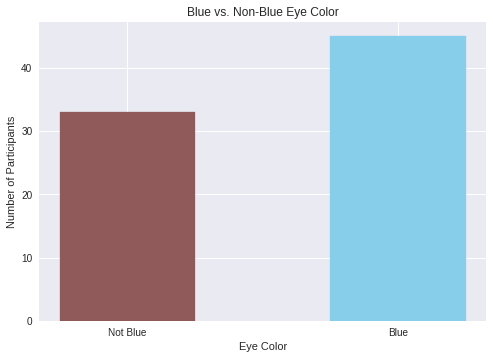

In [8]:
# create histogram of blue/not blue. TODO: make labels for graph
barlist = plt.bar([item[0] for item in items], [item[1] for item in items], .5)
barlist[0].set_color('#905a5a')
barlist[1].set_color('skyblue')
plt.title("Blue vs. Non-Blue Eye Color")
plt.xticks([0, 1], ["Not Blue", "Blue"])
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color")
plt.show()

In [ ]:
# 10-fold cross validation

svc_test = LinearSVC(penalty='l1', class_weight='balanced', dual=False, verbose=1, max_iter=10000)
cv_scores = cross_val_score(svc_test, knownData, leftEyeList, cv=10, scoring='accuracy')
print
print cv_scores.mean()
print cv_scores.std()

In [9]:
crange = np.logspace(-2, 1, 10).tolist()
means = []
stds = []
for Cval in crange:
    svc_test = LinearSVC(penalty='l1', class_weight='balanced', C=Cval, dual=False, verbose=1, max_iter=1000)
    cv_score = cross_val_score(svc_test, knownData, leftEyeList, cv=10, scoring='accuracy')
    means.append(cv_score.mean())
    stds.append(cv_score.std())
    print "c:", Cval, "mean:", cv_score.mean(), "std:", cv_score.std()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.01 mean: 0.45119047619 std: 0.0911109728443
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.0215443469003 mean: 0.884523809524 std: 0.0905979409173
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.0464158883361 mean: 0.884523809524 std: 0.0905979409173
[LibLinear][LibLinear][LibLinear]

/home/kfang/miniconda2/lib/python2.7/site-packages/sklearn/svm/base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.1 mean: 0.884523809524 std: 0.0905979409173
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.215443469003 mean: 0.884523809524 std: 0.0905979409173
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 0.464158883361 mean: 0.870238095238 std: 0.0821303954967
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 1.0 mean: 0.82123015873 std: 0.085866863392
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 2.15443469003 mean: 0.828968253968 std: 0.152167923182
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]c: 4.64158883361 mean: 0.563095238095 std: 0.227159231493
[LibLinear][LibLinear][LibLinear][LibLine

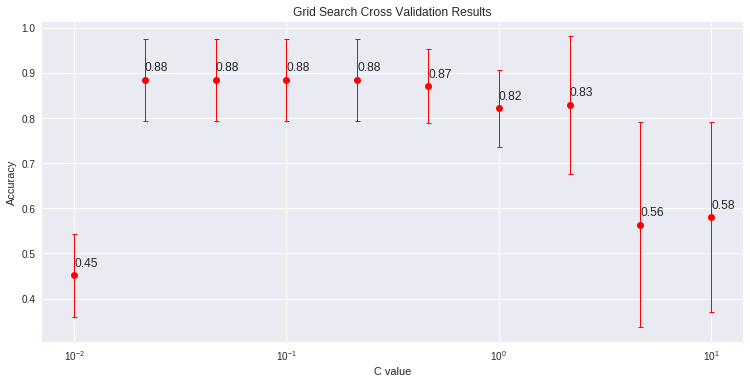

In [44]:
lines = plt.errorbar(crange, means, stds, marker='o', linewidth=0, elinewidth=1, capsize=20)
plt.xscale("log")
plt.title("Grid Search Cross Validation Results")
plt.setp(lines, color='r')
plt.xlabel("C value")
plt.ylabel("Accuracy")
    
for a, b in zip(crange, means): 
    plt.text(a, b+.02, np.around(b, decimals=2))


for cap in lines[1]:
    cap.set_markeredgewidth(1)
    cap.set_markersize(5)
    
plt.tight_layout()
plt.gcf().subplots_adjust(right=1.3)
plt.show()
plt.savefig('grid_search_results.png', dpi=300)

In [ ]:
# leave one out validation
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                     C=.06, dual=False, verbose=1, max_iter=1000)
from sklearn.model_selection import LeaveOneOut

leftOut = LeaveOneOut()
leftEyeList = np.asarray(leftEyeList)
scores = []
counter = 0
predicted = []
tested = []
for train_index, test_index in leftOut.split(knownData):
    X_train, X_test = knownData[train_index], knownData[test_index]
    y_train, y_test = leftEyeList[train_index], leftEyeList[test_index]
    svc_test.fit(X_train, y_train)
    y_pred = svc_test.predict(X_test)
    
    scores.append(accuracy_score(y_test, y_pred))
    predicted.append(y_pred)
    tested.append(y_test)
    
    counter += 1
    print "Iteration: " + str(counter) + ", correct: " + str(bool(y_test == y_pred))
    if not bool(y_test == y_pred):
        print "Incorrect: ", test_index

In [54]:
scores = []
for _ in range(31+38):
    scores.append(1)
for _ in range(2+7):
    scores.append(0)

In [55]:
scores = np.asarray(scores)
print scores.mean()
print scores.std()

0.884615384615
0.319485533189


In [ ]:
svc_test.fit(knownData, leftEyeList)

In [ ]:
print svc_test.predict([pgp[0]])

In [ ]:
# print results of leave one out validation
print np.mean(np.asarray(scores))
import collections
print collections.Counter(scores)

In [ ]:
# determining of the eye color can be solely determined by the tile at position 1792420. 
# While it is more accurate than the classifier 
guesses = []
for val in range(len(knownData)):
    one_hot = ['not blue', 'blue']
    tile = knownData[val][1792420]
    if tile < 0: # not blue
        guesses.append(0)
    else: # blue
        guesses.append(1)
print accuracy_score(leftEyeList, guesses)

In [ ]:
svc_test.fit(knownDataFiltered, leftEyeListFiltered)

# retrieve all the nonzero coefficients and zip them with their respective indices
nonzeroes = np.nonzero(svc_test.coef_[0])[0]
coefs = zip(nonzeroes, svc_test.coef_[0][nonzeroes])

# sort the coefficients by their value, instead of index
coefs.sort(key = lambda x: x[1], reverse=True)

for coef in coefs:
    print coef

In [ ]:
corrNames = np.asarray(corrNames)

print corrNames[62]

In [ ]:
svc_test.fit(knownDataFiltered, leftEyeListFiltered)

In [ ]:
print svc_test.predict(knownData[incorrTiles])
print leftEyeList[incorrTiles]

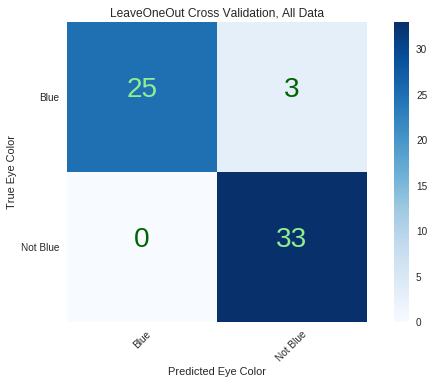

In [14]:
# create confusion matrix - code taken from Sarah's blood type prediction
#cnf_matrix = confusion_matrix(predicted, tested)
cnf_matrix = np.array([[25, 3], [0, 33]])
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('True Eye Color')
plt.xlabel('Predicted Eye Color')

classes = ['Blue','Not Blue']
plt.title("LeaveOneOut Cross Validation, All Data")
plt.grid('off')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        if cnf_matrix[i, j] > 20:
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     fontsize=28,
                     color="lightgreen")
        else:
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     fontsize=28,
                     color="darkgreen")

plt.gcf().subplots_adjust(left=0.25, bottom = 0.35)
plt.tight_layout()
plt.savefig('../images/blue_confusion_all_data.png',format='png',dpi=900)